# Shap Plots for Target Model 

Here, use Random Forest as an example to draw all shap plots 

In [12]:
# load dependencies 
import numpy as np 
import pandas as pd 
import shap 
import matplotlib
import sklearn
from sklearn.ensemble import RandomForestClassifier

print( shap.__version__ )
print( matplotlib.__version__ )
print( sklearn.__version__ )

0.42.1
3.8.0
1.3.0


## 0. Get the Data 

Obtain All Data (X,y), Train Data (train_x, train_y), Validation Data (val_x, val_y).

In [13]:
def get_data( csv_file ):
    data = pd.read_csv( csv_file ) 
    vars = data.columns
    xs, ys = data[ vars[2:-1] ], data[ [vars[-1]] ]
    return xs, ys 

def get_all_data( train_csv, val_csv ):
    train_data = pd.read_csv( train_csv )
    val_data = pd.read_csv( val_csv ) 
    vars = train_data.columns 
    print(vars)
    print( train_data.iloc[0] ) # need to omit the first two columns as they're not normal variables ... 
    train_x, train_y = train_data[ vars[2:-1] ], train_data[ [vars[-1]] ]
    val_x, val_y = val_data[ vars[2:-1] ], val_data[ [vars[-1]] ] 
    xs, ys = pd.concat( [train_x, val_x], axis=0 ), pd.concat( [train_y, val_y], axis=0 )
    print( f"All data's shape is {xs.shape}" )
    return xs, ys 

# all data 
X, y = get_all_data( "train.csv", "val.csv" ) 
X, y = X, y.values

# training data and validation data 
train_x, train_y = get_data( "train.csv" )
val_x, val_y = get_data( "val.csv" ) 

Index(['Unnamed: 0', 'ID', 'Gender', 'Age(y)', 'Diameter(mm)', 'Shape',
       'Margin', 'Cortex.size(mm)', 'Cortical.morphologic.features',
       'Nodal.echogenicity', 'Calcifications', 'Hilum', 'History.of.cancer',
       'Number.of.suspicious.axillary.lymphnodes',
       'Multiple.regions.of.suspicious.lymphnodes', 'Pathology'],
      dtype='object')
Unnamed: 0                                        415
ID                                           us713876
Gender                                              0
Age(y)                                             52
Diameter(mm)                                       29
Shape                                               0
Margin                                              0
Cortex.size(mm)                                    16
Cortical.morphologic.features                       2
Nodal.echogenicity                                  1
Calcifications                                      0
Hilum                                            

## 1. Train the Model and Get Results

Here, we only present the selected model's (Random Forest) results. 

acc is 0.8431372549019608, precision is 0.8414620217018846, recall is 0.8431372549019608, f1 score is 0.8416737601361948, specificity is 0.898989898989899, npv is 0.8640776699029126, auc is 0.9304152637485972.


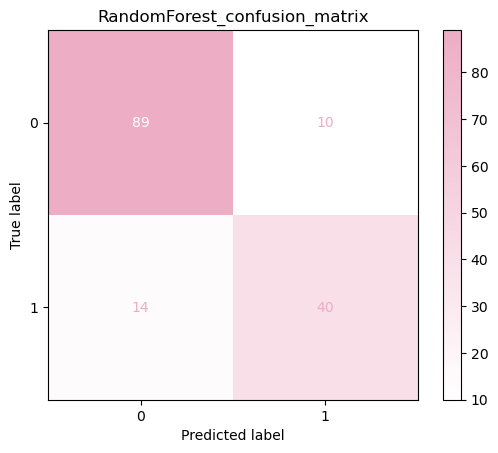

In [14]:
import os 
import shap
import numpy as np
from matplotlib import colors as plt_colors

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import sklearn.metrics as metrics
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

def get_data( csv_file ):
    data = pd.read_csv( csv_file ) 
    vars = data.columns
    xs, ys = data[ vars[2:-1] ], data[ [vars[-1]] ]
    return xs, ys 

# specificity = TN/(TN+FP)
def get_spe( curr_conf ):
    return curr_conf[0,0] / ( curr_conf[0,0]+curr_conf[0,1] )

# NPV = TN/(TN+FN) 
def get_npv( curr_conf ):         
    return curr_conf[0,0] / ( curr_conf[0,0]+curr_conf[1,0] ) 

def confusion_matrix_display( conf_mat, model_dict, selected_model, path ):

    start_color = np.array([255, 255, 255])     # white 
    end_color = np.array( model_dict[selected_model] )           # specified color 
    n_steps = 256                               # color transition 
    gradient = np.vstack([np.linspace(start_color[i], end_color[i], n_steps) for i in range(3)]).T
    gradient /= 255.0
    colormap = ListedColormap(gradient)

    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["0", "1"])
    disp = disp.plot( cmap=colormap )
    plt.title( f"{selected_model}_confusion_matrix" )
    plt.savefig( path + f"{selected_model}_confusion_matrix.jpg", bbox_inches='tight' ) 
    plt.show() 

model_dict = { "LogisticRegression":[234, 131, 121], "RandomForest":[237, 173, 197], "Xgboost":[97, 156, 217], 
                "Lightgbm":[170, 215, 200], "DecisionTree":[206, 170, 208], "SVM":[149, 132, 193], "KNN":[108, 190, 195] }

train_y, val_y = np.array(train_y).reshape(-1), np.array(val_y).reshape(-1)

if not os.path.exists( "shap/" ):
    os.mkdir( "shap/" )

if not os.path.exists( "shap/model_conf_mat/" ):
    os.mkdir( "shap/model_conf_mat/" )

path = "shap/model_conf_mat/"
selected_model = "RandomForest"

accs, precs, recalls, specs, npvs, f1s, aucs = [], [], [], [], [], [], []  

if selected_model == "RandomForest":
    model = RandomForestClassifier( criterion='gini', n_estimators=280, max_features='sqrt', max_depth=6 )
    model.fit( train_x, train_y )
    explainer = shap.TreeExplainer(model)  
    shap_values = explainer.shap_values(X) 



y_pred = model.predict( val_x )
y_probs = model.predict_proba( val_x )[:,1] 

acc = accuracy_score( val_y, y_pred ) 
precision = precision_score( val_y, y_pred, average="weighted" ) 
recall = recall_score( val_y, y_pred, average="weighted" ) 
f1 = f1_score( val_y, y_pred, average="weighted" ) 
auc = metrics.roc_auc_score( val_y, y_probs ) 
curr_conf = confusion_matrix( val_y, y_pred ) 
spec = get_spe(curr_conf) 
npv = get_npv(curr_conf) 

print( f"acc is {acc}, precision is {precision}, recall is {recall}, f1 score is {f1}, specificity is {spec}, npv is {npv}, auc is {auc}." )
confusion_matrix_display( curr_conf, model_dict, selected_model, path ) 

### 2. Shap Plots for Selected Model Interpretation 

We draw a series of Shap Plots to help us interpret Random Forest Prediction.

1. Summary Plot;
2. Force Plot;
3. Dependency Plot;
4. Decision Plot;
5. Interaction Plot;
6. Heatmap;
7. Waterfall Plot;

#### 2.1 Summary Plot (Importance Plot)

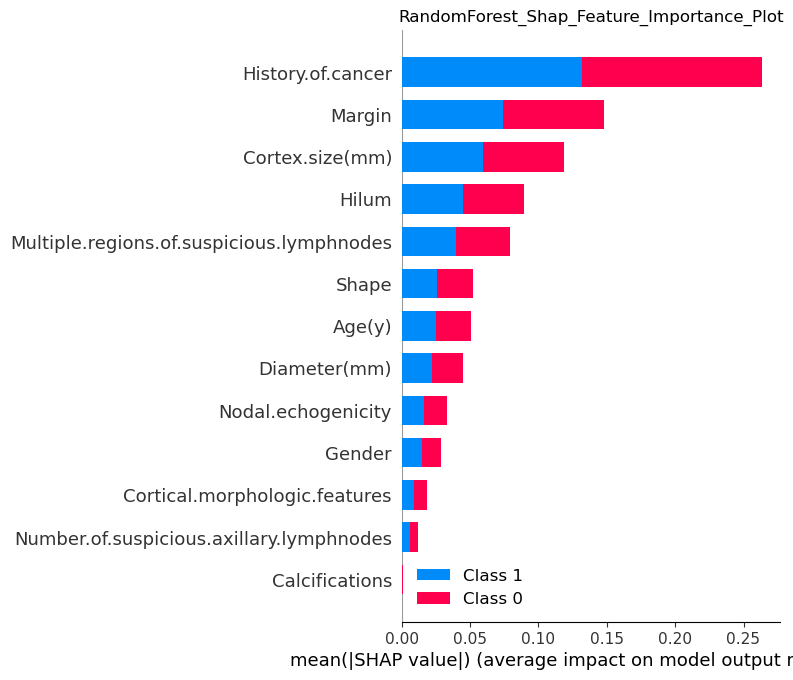

In [15]:
if not os.path.exists( "shap/importance_plots/" ):
    os.mkdir("shap/importance_plots/")

# selected_model = "RandomForest"
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.savefig( "shap/importance_plots/{}_Shap_Feature_Importance_Plot.jpg".format(selected_model), bbox_inches='tight' )
plt.title( "{}_Shap_Feature_Importance_Plot".format(selected_model) )
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


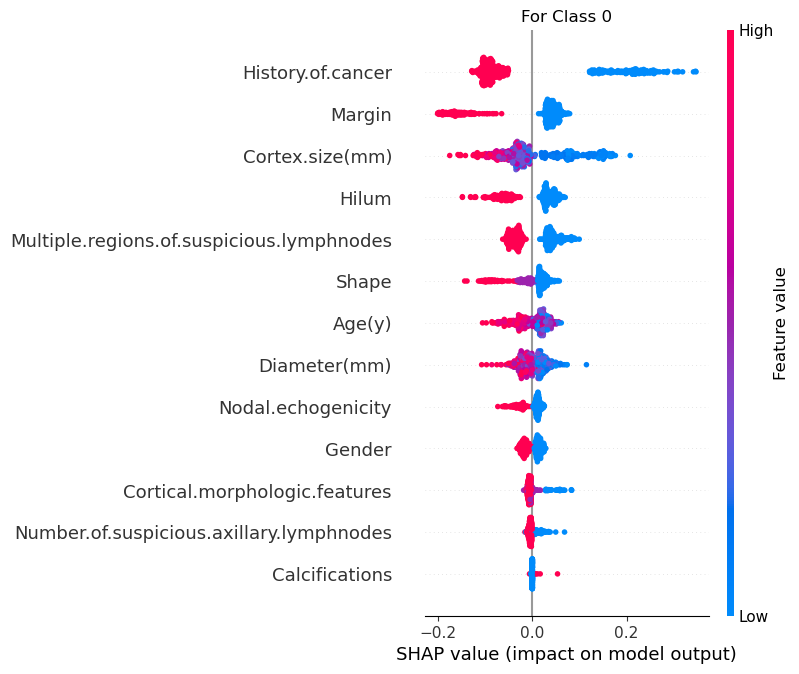

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


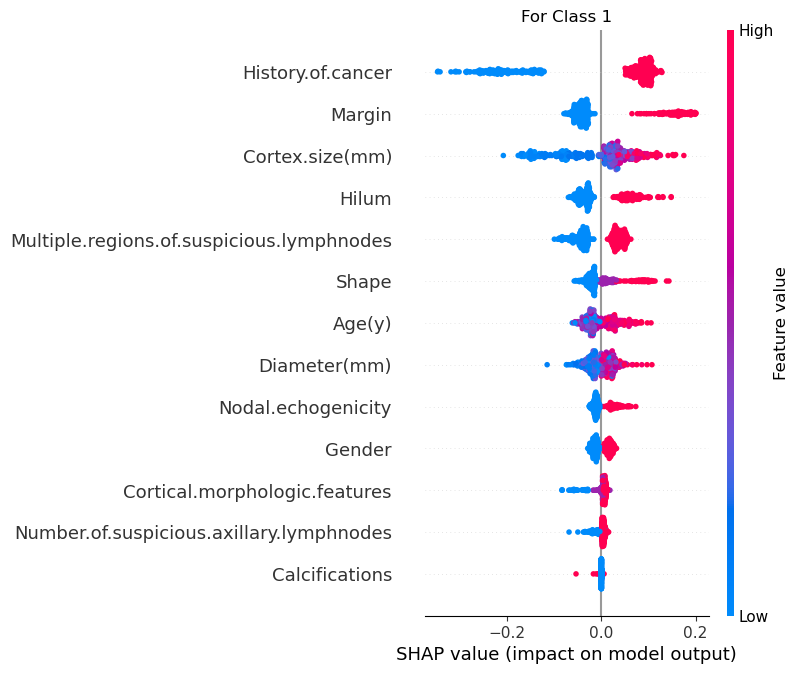

In [7]:

for i in range(2):
    shap.summary_plot(shap_values[i], X, show=False)
    plt.title( f"For Class {i}" )
    plt.savefig( f"shap/Summary_Plot_class_{i}.jpg", bbox_inches='tight' )
    plt.show()

#### 2.2 Force Plot 

(13, 2)
[[0]
 [1]]


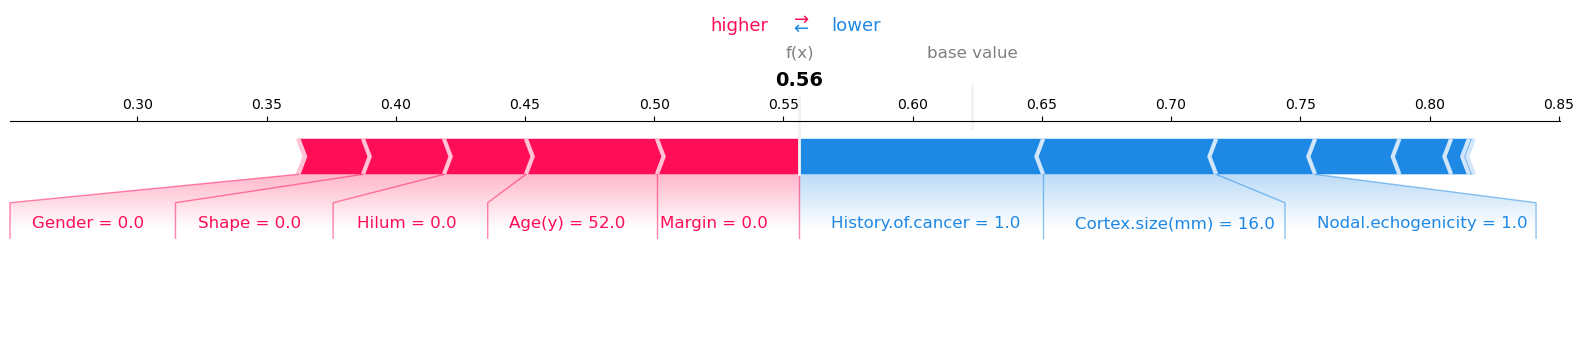

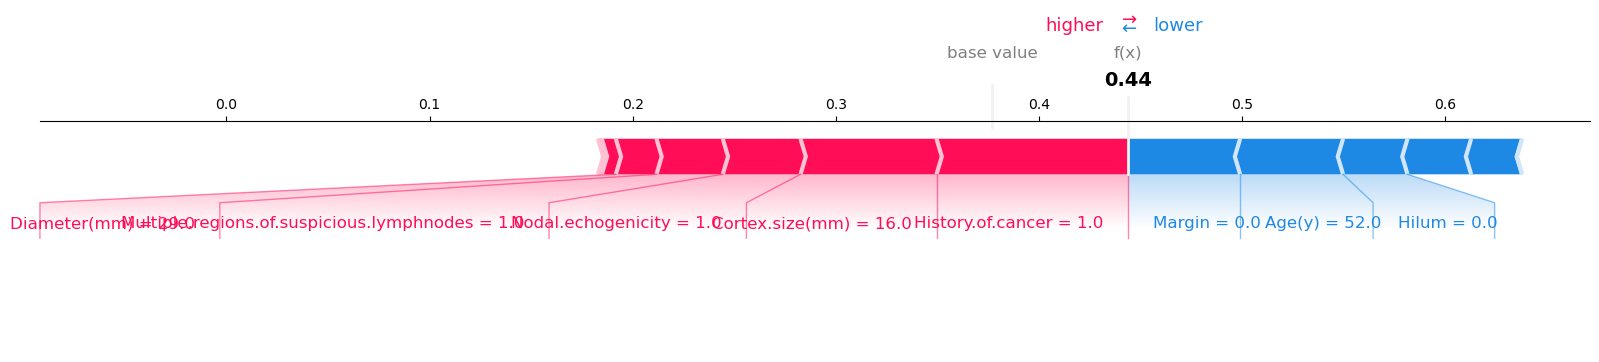

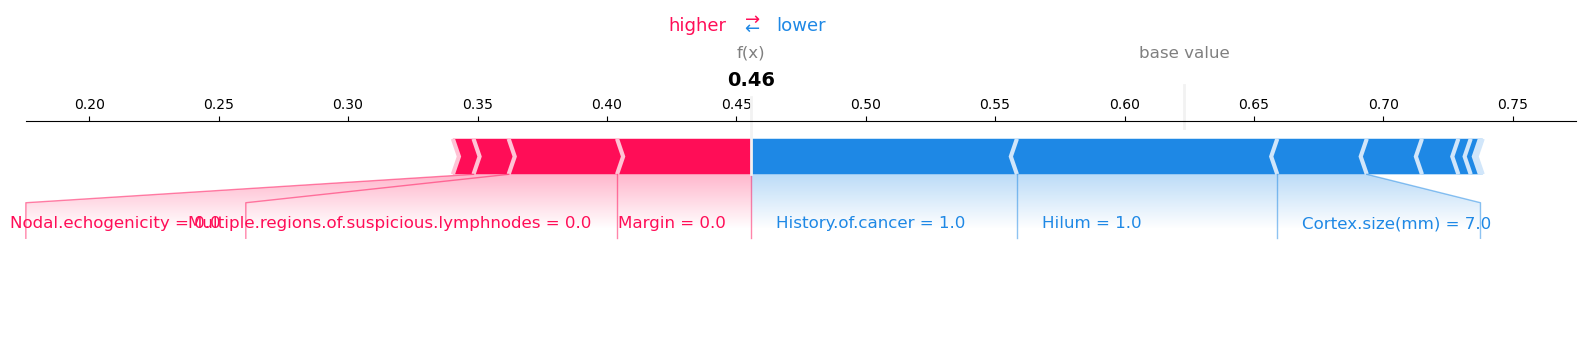

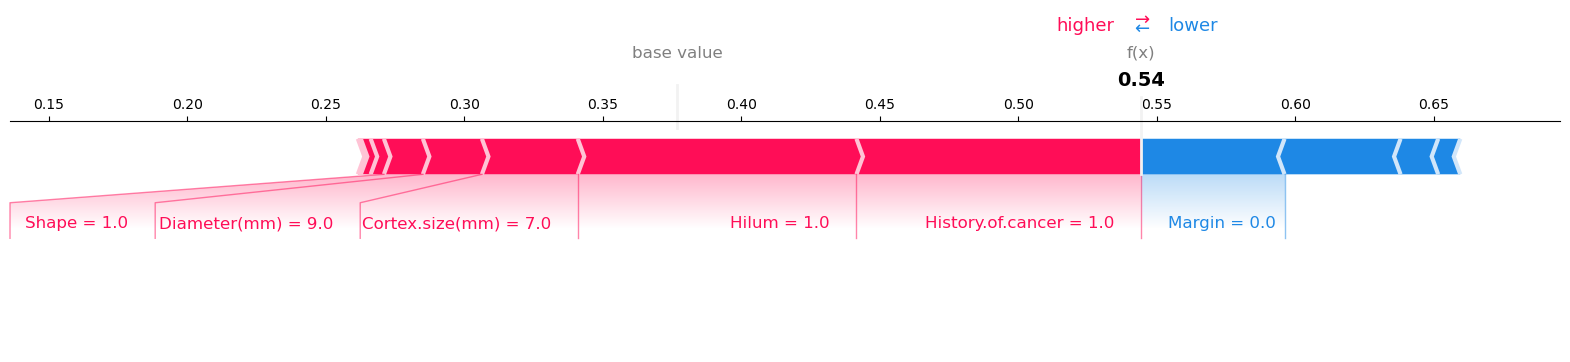

In [8]:
if not os.path.exists( "shap/single_force_plots" ):
    os.mkdir("shap/single_force_plots")

shap.initjs() 
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print(shap_values[0].shape)
cls_num = 2
sample_indexes = [0,1]
print(y[sample_indexes])

# # please set i (the i-th sample you want to plot single force plot for)
for index in sample_indexes:           # 2 classes
    for c in range(cls_num):       # 2 examples
        shap.plots.force( shap_values[index,:,c], show=False, matplotlib=True )
        plt.savefig( f"shap/single_force_plots/single_force_sample{index}_class{c}.jpg" )
plt.show()

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.force( shap_values[:,:,1] )

#### 2.3 Dependency Plot 

Here, we can draw partial dependency plot (shown below) and dependency plot bwtween any two variables.

all_var_list is Index(['Gender', 'Age(y)', 'Diameter(mm)', 'Shape', 'Margin',
       'Cortex.size(mm)', 'Cortical.morphologic.features',
       'Nodal.echogenicity', 'Calcifications', 'Hilum', 'History.of.cancer',
       'Number.of.suspicious.axillary.lymphnodes',
       'Multiple.regions.of.suspicious.lymphnodes'],
      dtype='object')
shap_obj's shape is  (508, 13, 2)
shap_obj.values[:,:,1]'s shape is  (508, 13)
(508, 13)


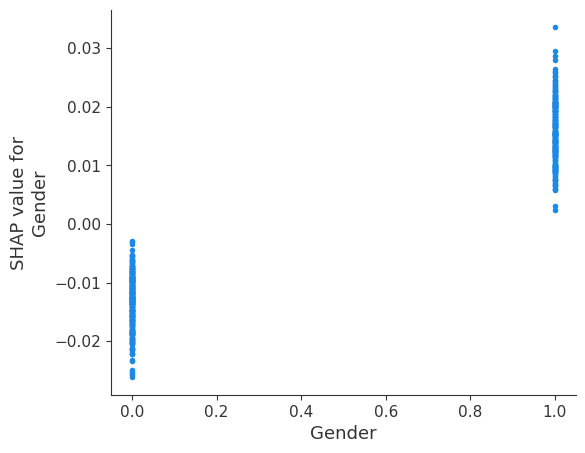

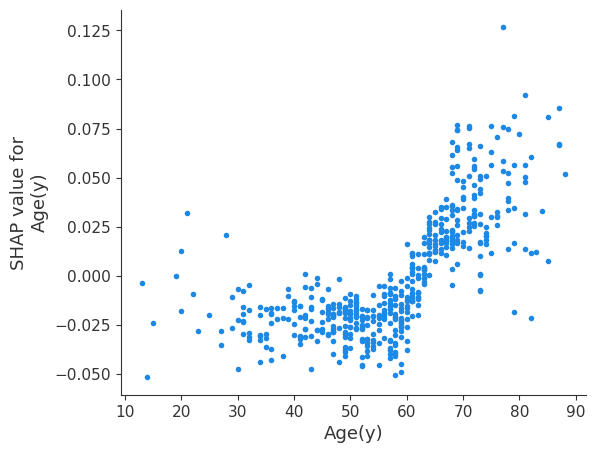

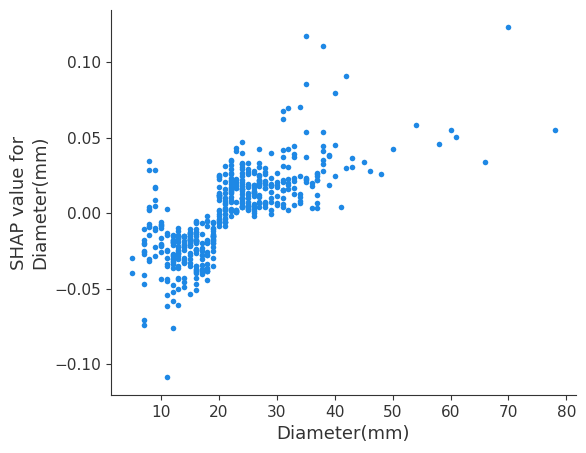

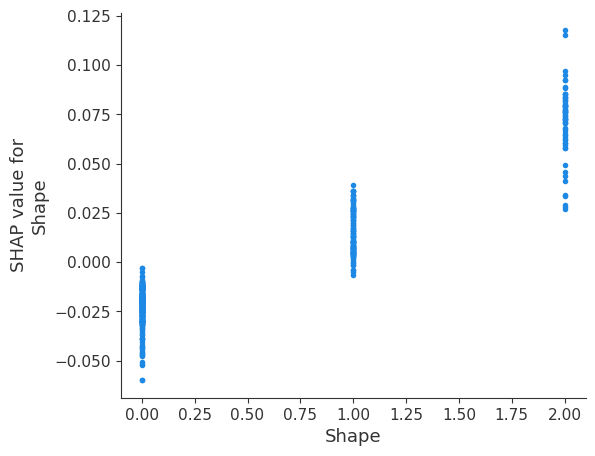

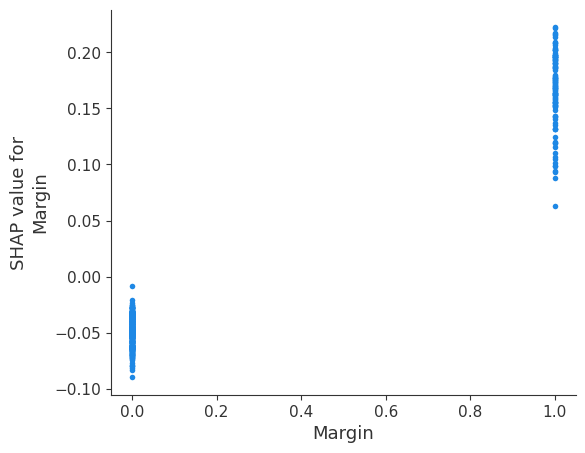

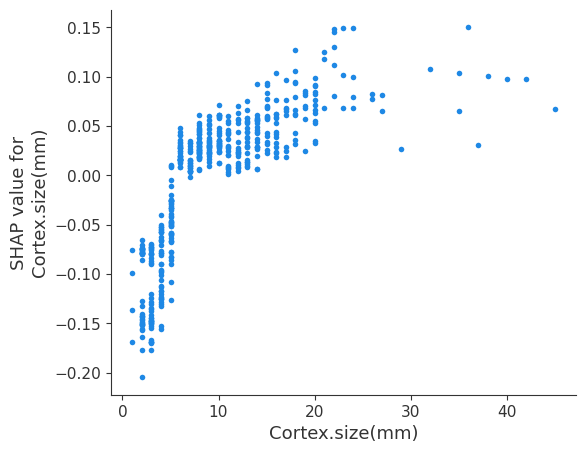

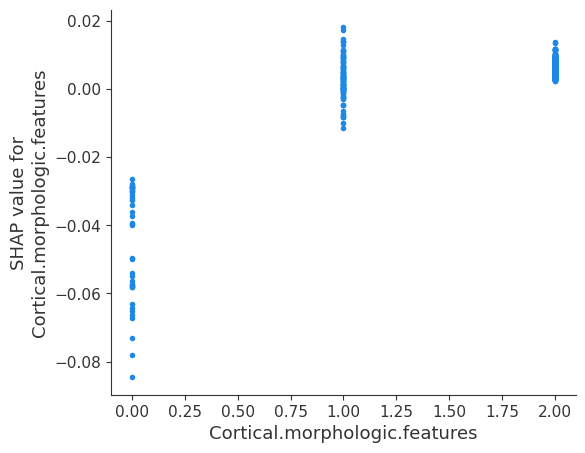

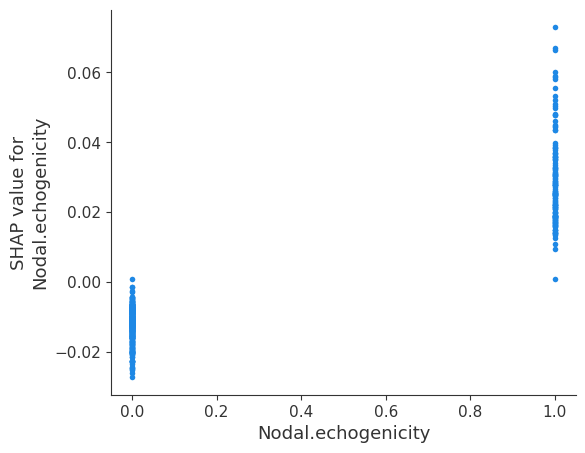

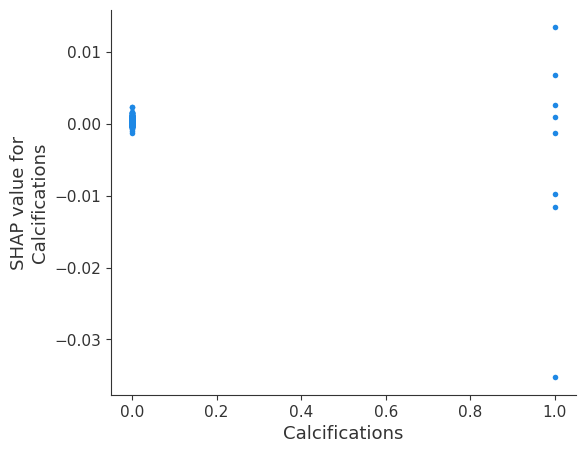

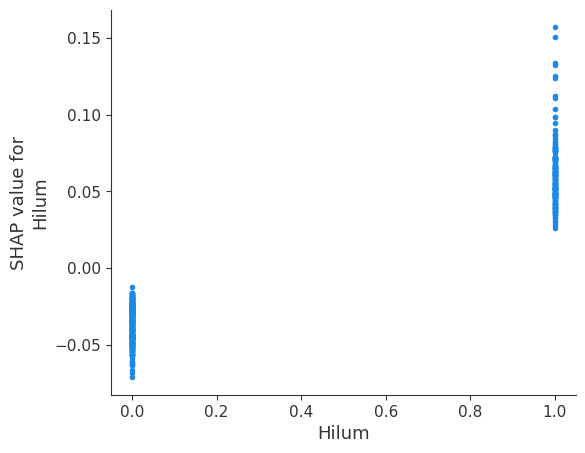

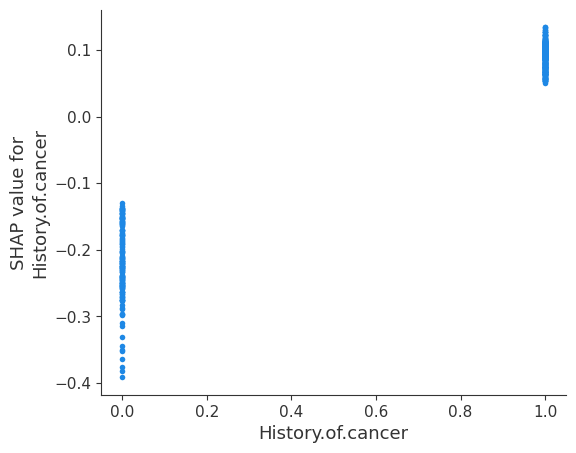

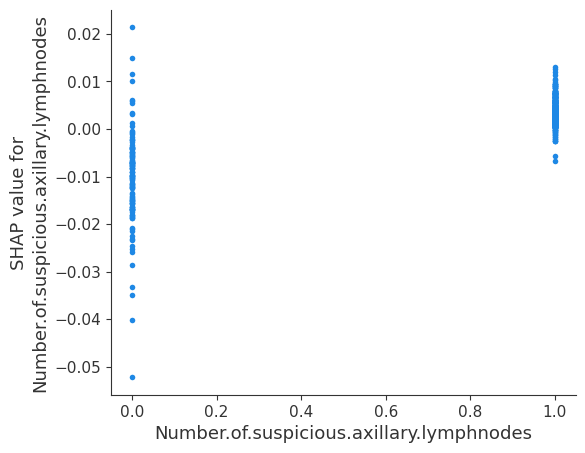

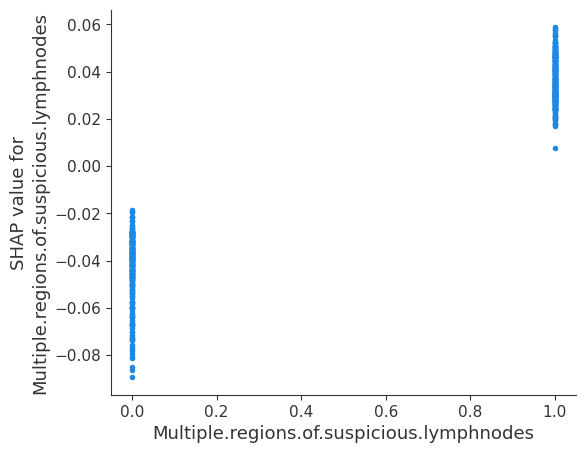

In [17]:
if not os.path.exists( "shap/dependency_plots/" ):
    os.mkdir("shap/dependency_plots/")

# obtain all variables 
data = pd.read_csv( "train.csv" ) 
all_var_list = data.columns[2:-1]
print( f"all_var_list is {all_var_list}" ) 

explainer = shap.TreeExplainer(model)
shap_obj = explainer(X)
print( "shap_obj's shape is ", shap_obj.shape )
print( "shap_obj.values[:,:,1]'s shape is ", shap_obj.values[:,:,1].shape )
print(X.shape)

# can specify interaction_index as a name of variables such that the color of dots will indicate the interactions between variables
for i in range(len(all_var_list)):
    shap.dependence_plot( all_var_list[i], shap_obj.values[:,:,1], X, display_features=X, interaction_index=None, show=False )
    plt.savefig( "shap/dependency_plots/Partial_Dependency_Plot_{}.jpg".format(all_var_list[i]) )
    plt.show()

#### 2.4.0 Decision Plot 

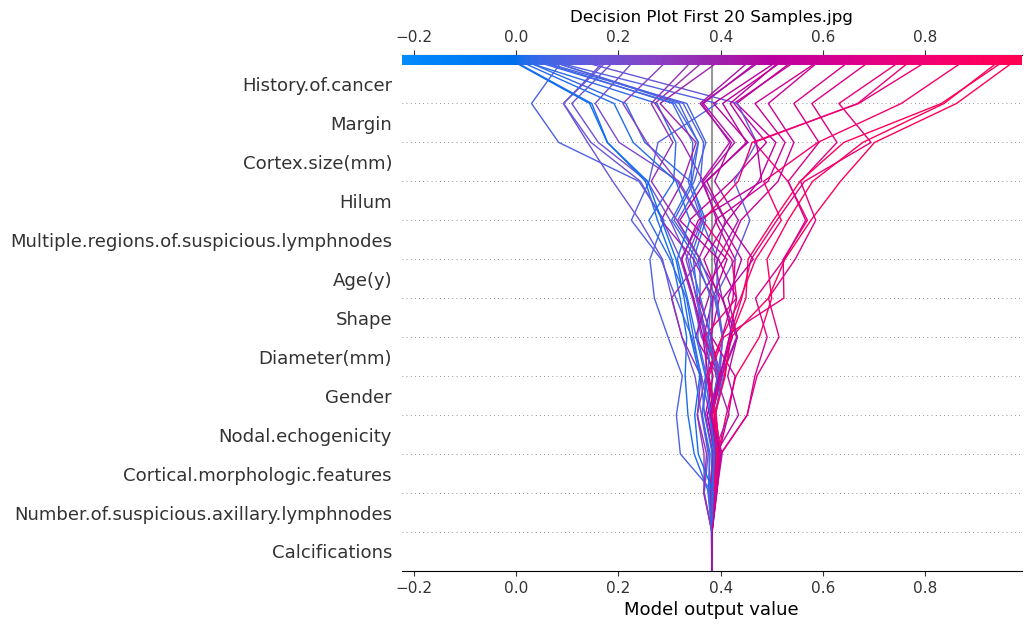

In [18]:
# Select a clip of our data and draw decision plot to show how to reach the predicted output
if not os.path.exists( "shap/decision_plots/" ):
    os.mkdir("shap/decision_plots/")
explainer = shap.TreeExplainer(model)
num = 20 
shap_values = explainer.shap_values(X.loc[ range(num) ]) 
i = 1
shap.decision_plot(explainer.expected_value[i], shap_values[i], X.loc[ range(num) ],
                   legend_location="lower right", show=False)
plt.title( f"Decision Plot First {num} Samples.jpg" )
plt.savefig( f"shap/decision_plots/DecisionPlot_Class{i}_First{num}.jpg", bbox_inches='tight' )
plt.show()

#### 2.4.1 Decision Plot for Mis-Classified Samples (in the first 100 data entries)

All mis-classified samples

(508,) (508,)
(56, 13)


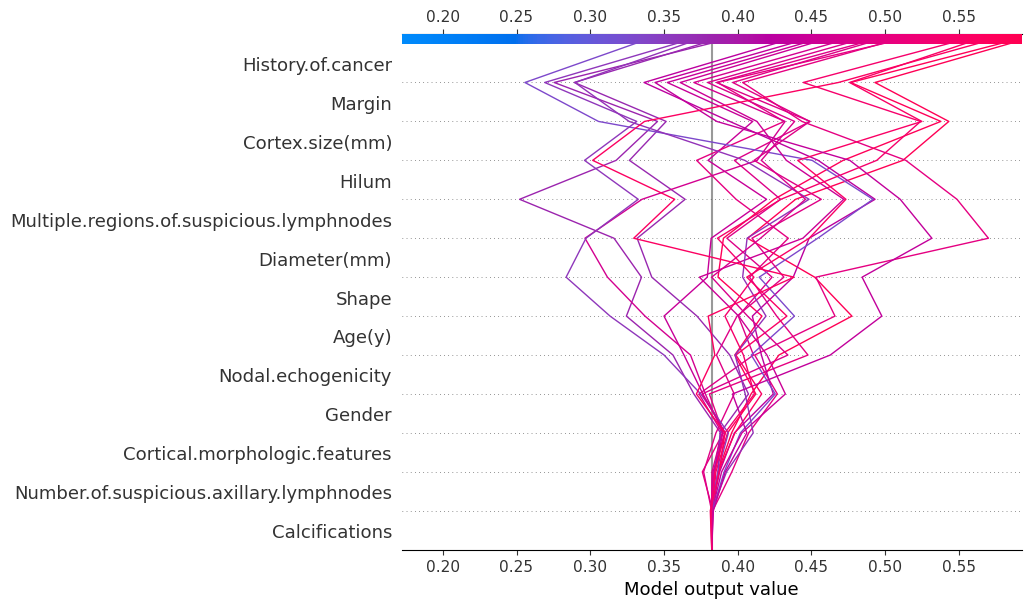

In [19]:
# Select some misclassified data and draw decision plot to show how Xgboost model makes wrong decisions 
# Select some misclassified data and draw decision plot to show how Xgboost model makes wrong decisions 
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

# select wrong predictions in the first 100 predictions to show their decision paths 
y_preds = model.predict(X) 
y_true = np.array( y )
y_true = y_true.reshape( (-1) )
print(y_preds.shape, y_true.shape)
sels = (y_preds != y_true )
print(X[ sels ].shape)

i, cutoff = 1, 20  # cutoff defines how many data points we need 
shap_values = explainer.shap_values( X[ sels ])
shap.decision_plot(expected_value[i], shap_values[i][:cutoff], X[sels][:cutoff],
                   legend_location="lower right", show=False) 

plt.savefig( f"shap/decision_plots/Decision_MisClassification_in_First100.jpg", bbox_inches='tight' )
plt.show()

#### 2.5 Interaction Plot 

2 (508, 13, 13)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


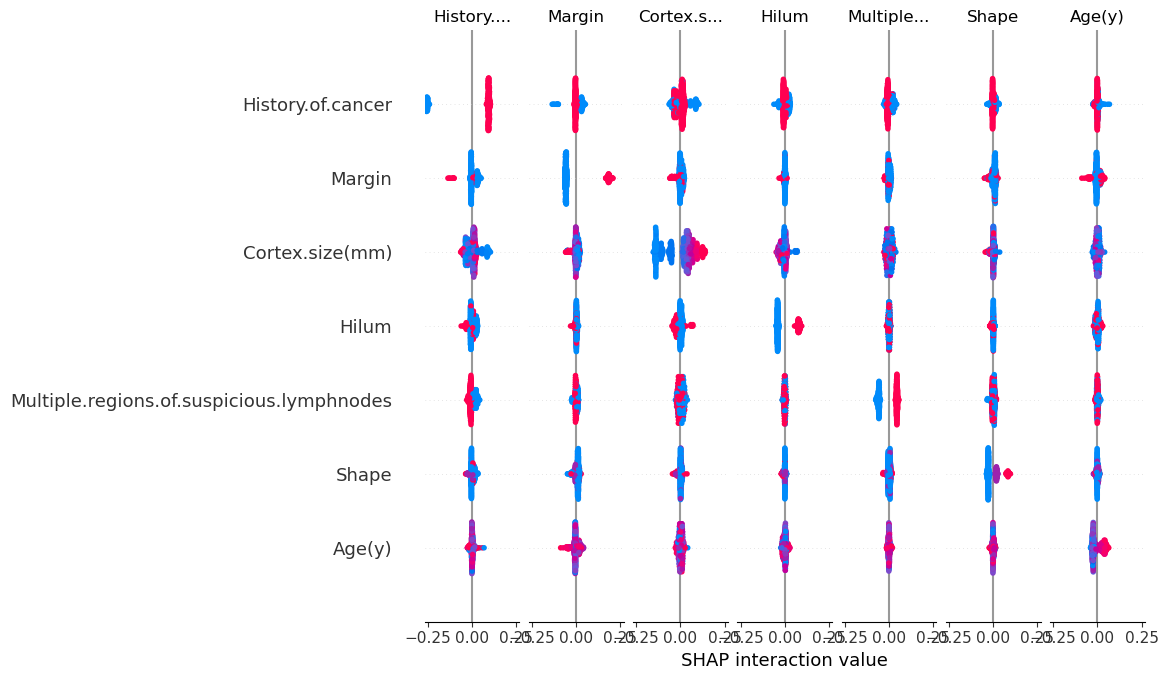

In [20]:
explainer = shap.TreeExplainer(model)
shap_interaction_values = explainer.shap_interaction_values(X)
print( len(shap_interaction_values), shap_interaction_values[1].shape )
shap.summary_plot(shap_interaction_values[1], X, show = False)
plt.savefig( "shap/Interaction_Plot.jpg", bbox_inches='tight' )
plt.show()

#### 2.6 Heatmap 

<class 'shap._explanation.Explanation'> 508 (13, 2)


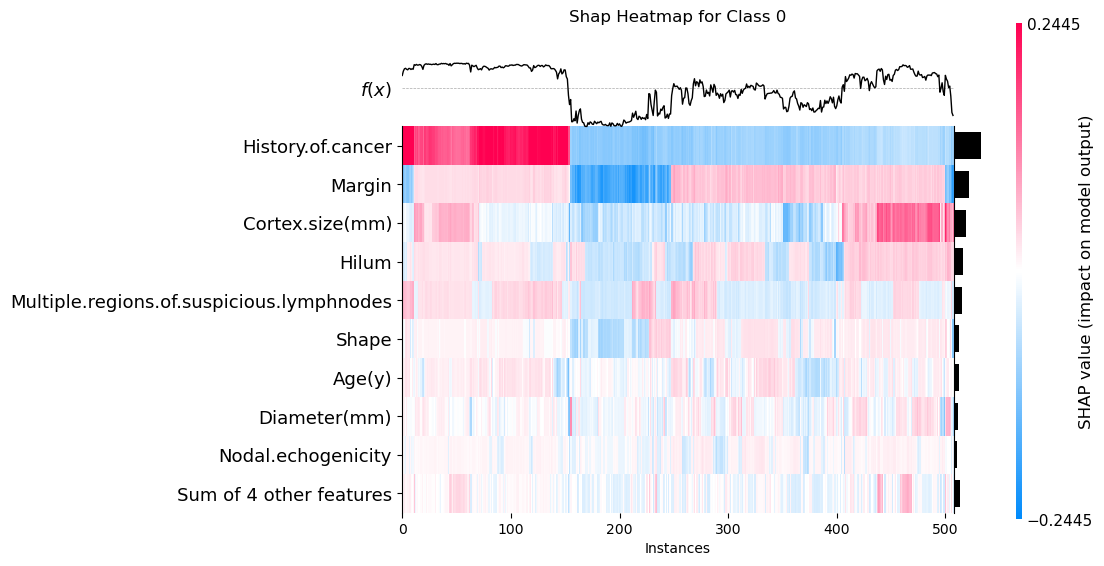

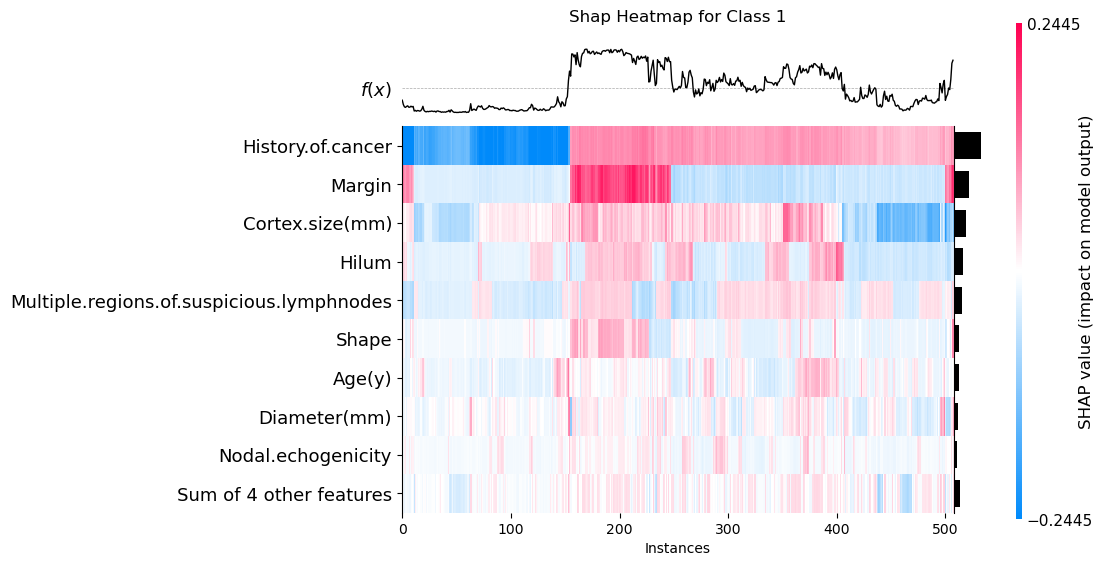

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
print( type(shap_values), len(shap_values), shap_values[0].shape )

for i in range(2):
    shap.plots.heatmap(shap_values[:,:,i], show=False)
    plt.title(f"Shap Heatmap for Class {i}")
    plt.savefig( f"shap/Shap_Heatmap_class{i}.jpg", bbox_inches='tight' )
    plt.show()

#### 2.7 Waterfall Plot 

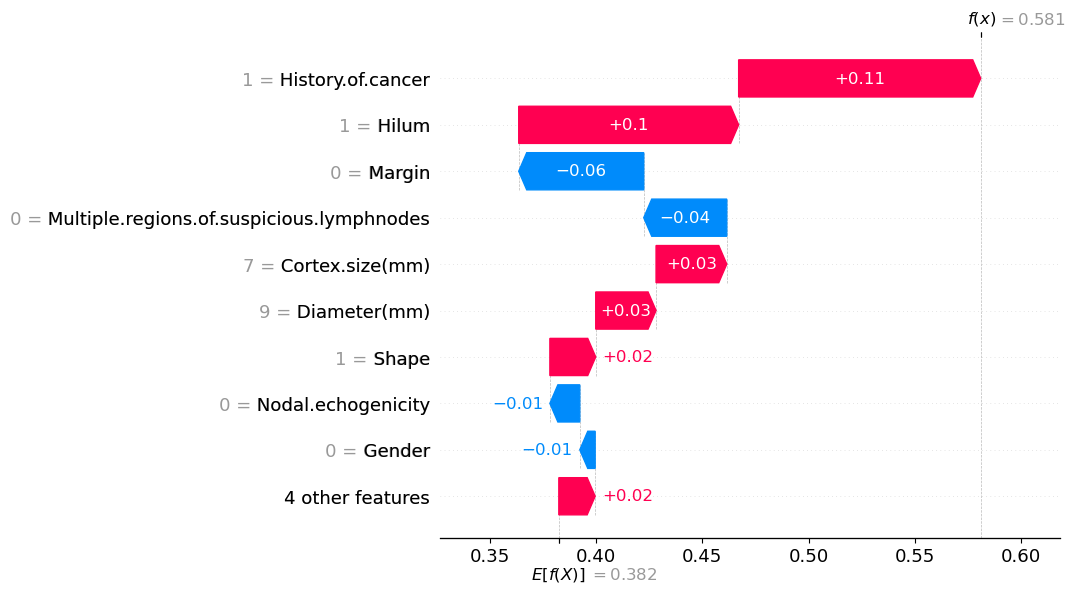

In [22]:
if not os.path.exists( "shap/waterfall_plots" ):
    os.mkdir("shap/waterfall_plots")
explainer = shap.TreeExplainer(model)
shap_obj = explainer(X)

index, i = 1, 1
shap.plots.waterfall(shap_obj[index,:,i], show=False)   # select waterfall plot for a single prediction
plt.savefig( f"shap/waterfall_plots/Waterfall_Plot_Sample_{index}_class_{i}.jpg", bbox_inches='tight' )
plt.show()